In [1]:
import tsp
import torch
import torchmetrics
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

import networkx as nx
from torch_geometric.utils import to_networkx


def viz_graph(data, labels, thresh=0.5, ax=None):
    color_orig = labels.view(1, -1)
    graph = to_networkx(data, to_undirected=False)
    pos = {i: p.numpy().tolist() for i, p in enumerate(data.pos)}

    color = np.r_[
        color_orig,
        np.zeros_like(color_orig), 
        np.zeros_like(color_orig), 
        np.ones_like(color_orig),
    ].T.astype('float64')

    color[color_orig[0] < thresh] *= 0.01
    if ax is None:
        _, ax = plt.subplots(figsize=(6, 6))
    nx.draw_networkx(graph, pos=pos, edge_color=color, with_labels=False, ax=ax, node_size=100)

In [3]:
model = tsp.utils.load_model(
    "/home/algo/shpakovych/repos/tsp/checkpoints",
    "trained_weights.ckpt",
)

In [4]:
binary_f1_score = torchmetrics.classification.BinaryF1Score()

In [5]:
knn = [2, 5, 7, 10, 15]
dataset = tsp.dataset.TSPDataset(
    root="/scratch/algo/shpakovych/tsp/dataset",
    split="train",
    transforms=tsp.dataset.transforms.Compose([
        tsp.dataset.transforms.MaxNodesTransform(100),
        tsp.dataset.transforms.KNNTransform(knn),
    ]),
)
print(dataset)
print(dataset[0])

KNNTransform: 100%|██████████| 1071/1071 [00:13<00:00, 77.63graph/s]

TSPDataset(root=/scratch/algo/shpakovych/tsp/dataset, split=train, size=1071)
Data(edge_index=[2, 2225], edge_attr=[2225, 6], y=[2225], pos=[89, 2])


In [6]:
f1_score_list = []
for data in tqdm(dataset):
    with torch.no_grad():
        proba = model.forward(data).sigmoid()
    f1_score = binary_f1_score(proba.ravel(), data.y)
    f1_score_list.append(f1_score)
f1_score_list = torch.tensor(f1_score_list)
print(f"Mean F1-score: {torch.mean(f1_score_list):.4f}")

100%|██████████| 1071/1071 [01:16<00:00, 13.94it/s]

Mean F1-score: 0.7847


In [7]:
data = dataset[17]
print(data)

Data(edge_index=[2, 2450], edge_attr=[2450, 6], y=[2450], pos=[98, 2])


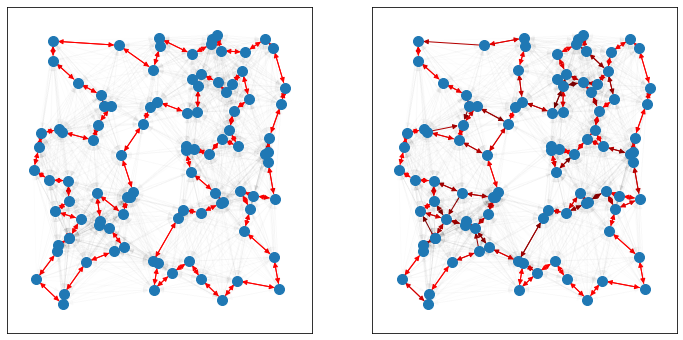

In [8]:
with torch.no_grad():
    proba = model.forward(data).sigmoid()

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
viz_graph(data, data.y, ax=axs[0])
viz_graph(data, proba, ax=axs[1])
plt.show()

In [9]:
from copy import copy

class Beam:

    eps = 1e-16

    def __init__(self, sequence, score=0., dist=0.):
        self.visited = set(sequence)
        self.sequence = sequence
        self.score = score
        self.dist = dist

    @staticmethod
    def proba_to_score(proba):
        return np.log(proba + Beam.eps)

    @staticmethod
    def from_edge_proba_dist(edge, proba, dist):
        sequence = [edge[0], edge[1]]
        score = Beam.proba_to_score(proba)
        return Beam(sequence, score, dist)

    def __contains__(self, node):
        return node in self.visited

    def append(self, node, proba, dist):
        self.visited.add(node)
        self.sequence.append(node)
        self.score += Beam.proba_to_score(proba)
        self.dist += dist

    def copy(self):
        return Beam(sequence=copy(self.sequence), score=self.score, dist=self.dist)

    @property
    def last_visited(self):
        return self.sequence[-1]

    def potential_score(self, proba):
        return self.score + Beam.proba_to_score(proba)
    
    def potential_dist(self, dist):
        return (self.dist + dist)

    def __repr__(self) -> str:
        return f"[{str(np.array(self.sequence))}, {self.score:.4f}, {self.dist:.4f}]"

In [10]:
width = 2000
dists = data.edge_attr[:, 0].numpy()
proba = model.forward(data).sigmoid().detach().ravel().numpy()
index = data.edge_index.numpy()
start = np.argsort(proba)[::-1][:width]

In [11]:
beam_list = [
    Beam.from_edge_proba_dist(
        edge=index[:, i],
        proba=proba[i], 
        dist=dists[i],
    ) 
    for i in start
]

for _ in range(len(data.pos) - 2):
    
    candidates = []
    for bi, beam in enumerate(beam_list):
        node = beam.last_visited
        mask = index[0] == beam.last_visited

        for nghb, prb, dist in zip(index[1, mask], proba[mask], dists[mask]):
            if nghb not in beam:
                candidates.append([bi, nghb, prb, dist])

    candidates = sorted(candidates, key=lambda x: beam_list[x[0]].potential_score(x[2]))[::-1]
    candidates = candidates[:width]

    updated_beam_list = []
    for candidat in candidates:
        beam = beam_list[candidat[0]].copy()
        beam.append(node=candidat[1], proba=candidat[2], dist=candidat[3])
        updated_beam_list.append(beam)
    
    beam_list = updated_beam_list


closure_mask = np.array([np.any((index[0] == beam.sequence[0])  & (index[1] == beam.sequence[-1])) for beam in beam_list])
beam_list = np.array(beam_list)
if closure_mask.size == 0:
    print("Search width is too small to find closed tour.")
else:
    closed_beam_list = beam_list[closure_mask]

Found tour with distance: 7.5959
Optimal tour distance: 7.6665
Data(edge_index=[2, 2450], edge_attr=[2450, 6], y=[2450], pos=[98, 2])


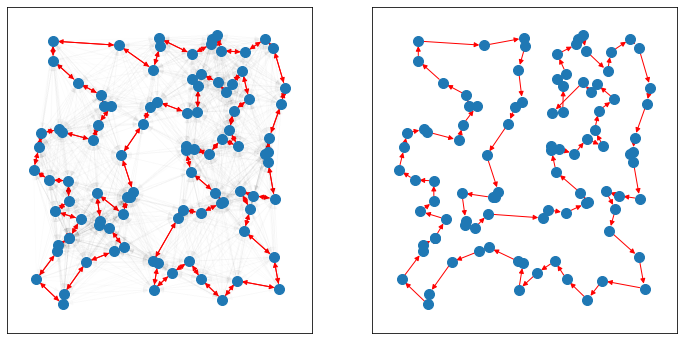

In [12]:
best_beam = sorted(closed_beam_list, key=lambda x: x.dist)[0]
optim_dist = data.edge_attr[:, 0][data.y.numpy().astype(bool)].sum() / 2.
print(f"Found tour with distance: {best_beam.dist:.4f}")
print(f"Optimal tour distance: {optim_dist:.4f}")

best_tour = best_beam.sequence[:]
best_tour.append(best_tour[0])

edge_index_0 = np.array(best_tour)
edge_index_tsp = np.array([edge_index_0[:-1], edge_index_0[1:]])
edge_index_tsp = edge_index_tsp[:, np.argsort(edge_index_tsp[0])]

from copy import deepcopy

dc_data = deepcopy(data)
dc_data.edge_index = torch.from_numpy(edge_index_tsp)

print(data)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
viz_graph(data, data.y, ax=axs[0])
viz_graph(dc_data, torch.ones((len(data.pos,))), ax=axs[1])
plt.show()